In [1]:
# import library
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd 
import cv2 
import io
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout, LSTM
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from itertools import groupby

In [2]:
# parameter
alphabets = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "
max_str_len = 19  # max length of input labels
num_of_characters = len(alphabets) + 1  # +1 for ctc pseudo blank
num_of_timestamps = 64  # max length of predicted labels
default_path = "/kaggle/input/college/clg handwritten/iam_words/"
# batch size
batch_size = 512

def label_to_num(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(alphabets.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_str_len, padding='post', value=len(alphabets))[0]

def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(alphabets):
                ans += alphabets[int(p)]
        
        text_list.append(ans)
        
    return text_list

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret += alphabets[ch]
    return ret
print(batch_size)


def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode image
    img = tf.image.decode_image(img, channels=1)

    # 3. Set the shape of the image tensor
    img.set_shape([None, None, 1])  # Assuming grayscale images

    # 4. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 5. Resize to the desired size
    img = tf.image.resize(img, [32, 128])
    
    return {"image": img, "label": label}



512


In [3]:
# load dataset
data = pd.read_excel('/kaggle/input/excel-for-iam-dataset/data.xlsx')
data = pd.DataFrame(data, columns = ['Fpath','Identify']).astype(str)

# remove some images in dataset with the NaNs label
data.dropna(axis=0, inplace=True)
print(data.shape)   

# separate data into train or valid
# Chọn ngẫu nhiên 90% các hàng cho phần train
train = data.sample(frac=0.9, random_state=42)
unique_train = train['Fpath'].unique()
# Chọn các hàng còn lại cho phần validation
valid = data.drop(train.index)
# view
print(train.shape)
print(valid.shape)
print(data.shape)

(115318, 2)
(103786, 2)
(11532, 2)
(115318, 2)


In [4]:
train = train[0:80000]
valid = valid[0:8000]
# reset index
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

vocab = set("".join(map(str, valid['Identify'])))
print(sorted(vocab))
vocab = set("".join(map(str, train['Identify'])))
print(sorted(vocab))

[' ', '!', '#', '&', '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[' ', '!', '#', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
# size of dataset
train_size = 80000
valid_size = 8000
print(valid_size)

8000


In [6]:
# create list for image data
train_x = []
valid_x = []

# i is params for getting image or label, count is params for loop 
# import image into train_x and valid_x
for i in range(valid_size):
    path= valid.loc[i, 'Fpath']
    img_dir = default_path + path    
    valid_x.append(img_dir)

for i in range(train_size):
    path= train.loc[i, 'Fpath']
    img_dir = default_path + path
    train_x.append(img_dir)

# label for valid data
valid_y = []
for i in range(valid_size):
    string = valid.loc[i, 'Identify']
    valid_y.append(label_to_num(string))

# label for train data
train_y = []
for i in range(train_size):
    string = train.loc[i, 'Identify']
    train_y.append(label_to_num(string))
    
print(len(valid_y))
print(len(train_y))

.
.
,
,
.
,
#
.
,
.
&
;
,
&
;
&
;
,
.
&
;
&
;
.
.
.
&
;
.
,
.
,
-
-
&
;
.
.
.
.
-
.
-
&
;
.
.
&
;
.
,
&
;
-
-
.
.
&
;
.
.
.
&
;
#
.
.
&
;
.
&
;
&
;
-
.
,
.
,
:
&
;
-
:
&
;
,
:
,
.
.
,
.
.
.
.
.
&
;
.
&
;
.
,
-
.
-
.
-
.
.
,
.
.
&
;
&
;
-
.
,
&
;
.
&
;
,
&
;
:
,
,
.
.
,
.
,
&
;
.
.
.
.
,
.
.
,
.
,
-
,
-
-
,
-
,
,
,
.
,
,
.
-
,
,
-
,
.
,
,
,
-
.
.
,
,
,
.
,
.
.
&
;
.
&
;
.
.
,
-
.
.
,
,
.
.
.
-
,
&
;
.
.
,
&
;
.
,
,
,
,
,
.
,
.
-
-
.
.
-
.
,
,
&
;
&
;
&
;
&
;
,
,
.
,
&
;
&
;
.
&
;
.
.
,
.
-
.
.
.
.
,
.
/
-
,
.
&
;
,
&
;
&
;
.
.
.
,
,
&
;
,
&
;
.
,
&
;
&
;
.
,
,
,
&
;
.
.
-
.
&
;
.
,
.
.
.
-
&
;
.
-
,
,
.
-
.
-
&
;
,
?
.
.
.
-
,
,
;
&
;
&
;
.
-
,
,
&
;
.
?
?
,
.
#
.
.
.
,
.
.
,
.
.
.
.
.
.
.
.
.
.
.
-
,
?
,
.
.
.
.
,
&
;
.
.
.
!
.
-
,
.
.
#
.
,
.
-
,
,
:
.
.
,
&
;
&
;
&
;
&
;
,
,
#
,
.
-
-
.
.
,
,
&
;
.
&
;
,
.
(
.
,
.
&
;
&
;
,
&
;
&
;
.
&
;
,
,
.
.
,
.
.
&
;
&
;
,
&
;
&
;
,
&
;
,
.
)
-
&
;
)
,
;
(
&
;
,
.
.
,
.
,
,
.
,
,
.
-
.
,
-
&
;
.
-
&
;
,
.
,
,
.
,
&
;
.
.
-
&
;
&
;
.
,
,
,
,
,
,


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

valid_dataset = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
valid_dataset = (
    valid_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [8]:
valid_y[0]

array([17, 10, 28, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63,
       63, 63], dtype=int32)

In [3]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [4]:
input_data = Input(shape=(32, 128, 1), name='image')
labels = layers.Input(name="label", shape=(None,), dtype="float32")

inner = Conv2D(32, (3, 3), padding='same', name='conv1', activation='selu')(input_data)
inner = MaxPool2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', activation='selu')(inner)
inner = MaxPool2D(pool_size=(2, 2), name='max2')(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', activation='selu')(inner)
inner = Conv2D(128, (3, 3), padding='same', name='conv4', activation='selu')(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv5', activation='selu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv6', activation='selu')(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv7', activation='selu')(inner)
inner = Conv2D(512, (3, 3), padding='same', name='conv8', activation='selu')(inner)
inner = MaxPool2D(pool_size=(2, 1), name='max8')(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv9',  activation='selu')(inner)
inner = BatchNormalization()(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv10', activation='selu')(inner)
inner = BatchNormalization()(inner)
inner = MaxPool2D(pool_size=(2, 1), name='max10')(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(64, (2,2), name='conv11', activation='selu')(inner)
inner = Dropout(0.2)(inner)

# CNN to RNN
squeezed = Lambda(lambda x: K.squeeze(x, 1))(inner)
# RNN
inner = Bidirectional(LSTM(128, return_sequences=True), name='lstm1')(squeezed)
inner = Bidirectional(LSTM(512, return_sequences=True), name='lstm2')(inner)
inner = Bidirectional(LSTM(512, return_sequences=True), name='lstm3')(inner)
inner = Bidirectional(LSTM(512, return_sequences=True), name='lstm4')(inner)
inner = Bidirectional(LSTM(128, return_sequences=True), name='lstm5')(inner)
dense_= Dense(128,activation = 'relu')(inner)
# OUTPUT
y_pred = Dense(num_of_characters,activation = 'softmax', name='dense2')(dense_)
output = CTCLayer(name="ctc_loss",)(labels, y_pred)

In [5]:
# model for test
model = Model(inputs=input_data, outputs=y_pred)
model.summary()

# model for train
train_model = Model(inputs=[input_data, labels], outputs=output)
train_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 128, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 32, 128, 32)       320       
                                                                 
 max1 (MaxPooling2D)         (None, 16, 64, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 64, 64)        18496     
                                                                 
 max2 (MaxPooling2D)         (None, 8, 32, 64)         0         
                                                                 
 conv3 (Conv2D)              (None, 8, 32, 128)        73856     
                                                                 
 conv4 (Conv2D)              (None, 8, 32, 128)        147584

In [12]:
train_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0),
                    metrics=[tf.keras.metrics.Accuracy()])

filepath = "/kaggle/working/best_model.h5"

# function callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor= 'val_loss',
                             verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=15)

callbacks_list = [checkpoint, earlyStopping]

# method 1
history = train_model.fit(train_dataset,
                          epochs=150,
                          validation_data=valid_dataset,
                          verbose = 1,
                          shuffle=True,   
                          callbacks=callbacks_list)

# method 2
# history = train_model.fit(dataset_final, epochs=10, verbose=1)
model.save('/kaggle/working/my_model.h5')

Epoch 1/150
157/157 [==============================] - ETA: 0s - loss: 16.2033 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 14.27847, saving model to /kaggle/working/best_model.h5
157/157 [==============================] - 274s 2s/step - loss: 16.2033 - accuracy: 0.0000e+00 - val_loss: 14.2785 - val_accuracy: 0.0000e+00
Epoch 2/150
157/157 [==============================] - ETA: 0s - loss: 12.2495 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 14.27847 to 12.26494, saving model to /kaggle/working/best_model.h5
157/157 [==============================] - 143s 906ms/step - loss: 12.2495 - accuracy: 0.0000e+00 - val_loss: 12.2649 - val_accuracy: 0.0000e+00
Epoch 3/150
157/157 [==============================] - ETA: 0s - loss: 10.6447 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 12.26494
157/157 [==============================] - 146s 929ms/step - loss: 10.6447 - accuracy: 0.0000e+00 - val_loss: 13.7843 - val_accuracy: 0.0000e+00
Epoch 4/150
157/157

In [13]:
# show correct accuracy
model.load_weights('/kaggle/working/best_model.h5')
prediction = []
for batch in valid_dataset.as_numpy_iterator():
    preds = model.predict(batch)
    prediction.extend(ctc_decoder(preds))

y_true = valid.loc[0:valid_size, 'Identify']
correct_char = 0
total_char = 0
correct = 0
for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr:
        correct += 1

print('Correct characters predicted : %.2f%%' % (correct_char * 100 / total_char))
print('Correct words predicted      : %.2f%%' % (correct * 100 / valid_size))

/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/10 [==============================] - 0s 32ms/step
Correct characters predicted : 76.24%
Correct words predicted      : 60.29%


In [14]:
model.load_weights('/kaggle/working/my_model.h5')
prediction = []
for batch in valid_dataset.as_numpy_iterator():
    preds = model.predict(batch)
    prediction.extend(ctc_decoder(preds))
y_true = valid.loc[0:valid_size, 'Identify']
correct_char = 0
total_char = 0
correct = 0
for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr:
        correct += 1

print('Correct characters predicted : %.2f%%' % (correct_char * 100 / total_char))
print('Correct words predicted      : %.2f%%' % (correct * 100 / valid_size))

10/10 [==============================] - 0s 33ms/step
Correct characters predicted : 79.17%
Correct words predicted      : 63.30%


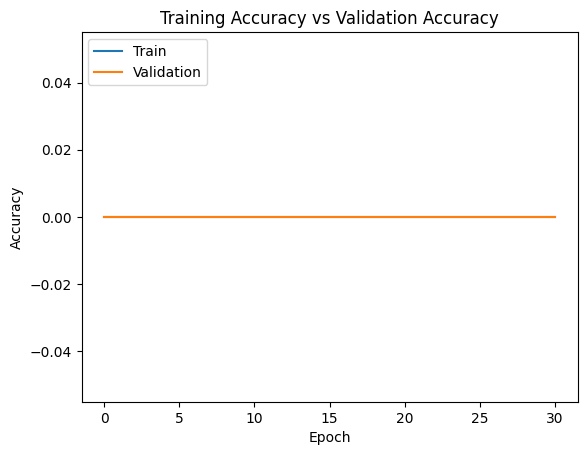

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

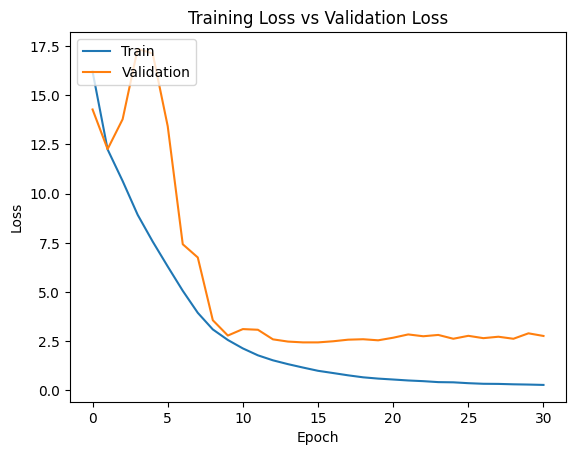

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
import pickle

# Lưu lịch sử huấn luyện thành file
with open('/kaggle/working/history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [8]:
test_data = pd.read_excel('/Users/rishavghosh/Downloads/data/bookok.xlsx')
test_data = pd.DataFrame(test_data, columns = ['Fpath','Identify']).astype(str)

In [9]:
test_data.dropna(axis=0, inplace=True)
print(test_data.shape)

(15, 2)


In [10]:
test_data.reset_index(inplace=True, drop=True)

In [11]:
default_path = "/Users/rishavghosh/Downloads/data/"
test_x = []
for i in range(len(test_data)):
    path= test_data.loc[i, 'Fpath']
    img_dir = default_path + path    
    test_x.append(img_dir)

In [12]:
test_x

['/Users/rishavghosh/Downloads/data/words/a.jpg',
 '/Users/rishavghosh/Downloads/data/words/b.jpg',
 '/Users/rishavghosh/Downloads/data/words/c.jpeg',
 '/Users/rishavghosh/Downloads/data/words/d.jpeg',
 '/Users/rishavghosh/Downloads/data/words/e.jpeg',
 '/Users/rishavghosh/Downloads/data/words/f.jpeg',
 '/Users/rishavghosh/Downloads/data/words/g.jpeg',
 '/Users/rishavghosh/Downloads/data/words/h.jpeg',
 '/Users/rishavghosh/Downloads/data/words/i.jpeg',
 '/Users/rishavghosh/Downloads/data/words/j.jpeg',
 '/Users/rishavghosh/Downloads/data/words/k.jpeg',
 '/Users/rishavghosh/Downloads/data/words/l.jpeg',
 '/Users/rishavghosh/Downloads/data/words/m.jpeg',
 '/Users/rishavghosh/Downloads/data/words/n.jpeg',
 '/Users/rishavghosh/Downloads/data/words/o.jpeg']

In [13]:
test_y = []
for i in range(len(test_data)):
    string = test_data.loc[i, 'Identify']
    test_y.append(label_to_num(string))

In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

test_dataset = (
    test_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [13]:
model.load_weights('/Users/rishavghosh/Downloads/best_model.h5')

prediction = []
for batch in test_dataset.as_numpy_iterator():
    preds = model.predict(batch)
    prediction.extend(ctc_decoder(preds))

y_true = test_data.loc[0:len(test_data), 'Identify']
correct_char = 0
total_char = 0
correct = 0
for i in range(len(test_data)):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr:
        correct += 1

print('Correct characters predicted : %.2f%%' % (correct_char * 100 / total_char))
print('Correct words predicted      : %.2f%%' % (correct * 100 / len(test_data)))

/Users/rishavghosh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


2/2 [==============================] - 11s 2s/step
Correct characters predicted : 56.13%
Correct words predicted      : 13.21%


In [14]:
preds

array([[[2.18273266e-09, 2.91820422e-11, 3.35976583e-05, ...,
         2.27454336e-07, 2.44387564e-07, 7.07993098e-03],
        [1.79021326e-10, 9.26568752e-11, 2.93753226e-04, ...,
         4.14986971e-06, 1.85128197e-08, 6.19988330e-03],
        [2.21123432e-11, 3.01415360e-12, 2.59373991e-07, ...,
         4.39965220e-08, 3.91324129e-09, 9.86346304e-01],
        ...,
        [3.44573545e-14, 6.65197132e-14, 5.85257745e-11, ...,
         1.23937312e-07, 2.62924571e-09, 9.97325778e-01],
        [4.52436838e-11, 1.03919796e-10, 3.55746499e-09, ...,
         9.15837154e-06, 1.67486476e-07, 8.38832200e-01],
        [1.20666456e-07, 1.81515230e-08, 3.93112828e-07, ...,
         4.12241279e-05, 4.21559753e-06, 3.63154560e-01]],

       [[1.76252701e-08, 9.36899447e-10, 1.42301421e-03, ...,
         1.73728986e-04, 8.25163315e-09, 2.74067484e-02],
        [8.16285511e-11, 9.26265037e-11, 7.01933532e-05, ...,
         8.15008389e-05, 4.27227121e-07, 1.67499576e-02],
        [3.23113758e-11, 

In [15]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, prediction)
acc

0.1320754716981132

prediction value =  Afte


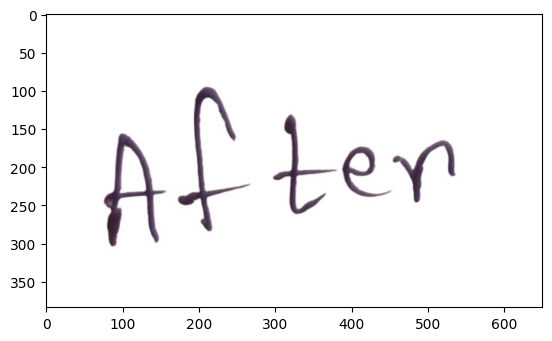

prediction value =  sall


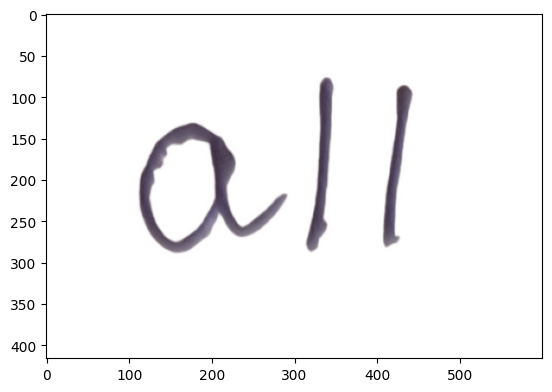

prediction value =  smong


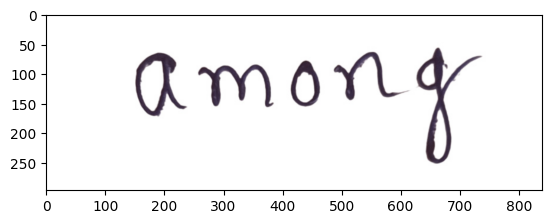

prediction value =  around


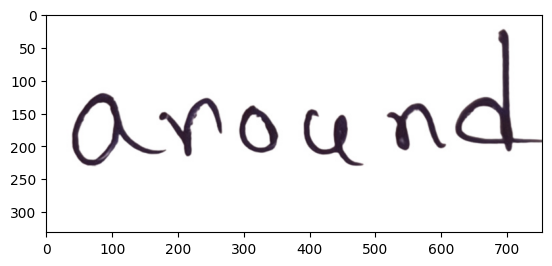

prediction value =  assked


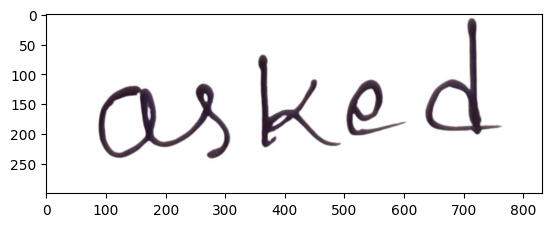

prediction value =  sheck


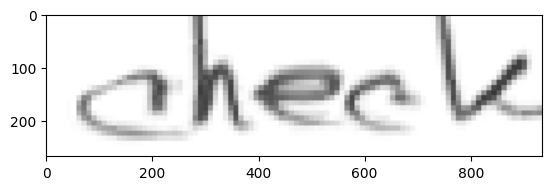

prediction value =  Colunn


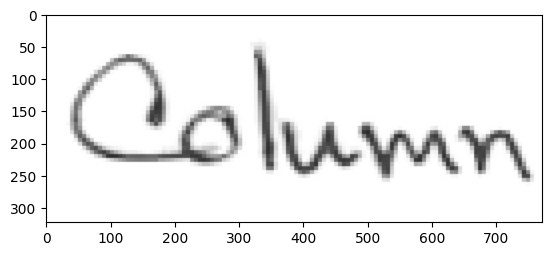

prediction value =  coverred


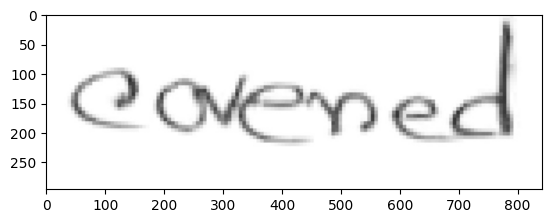

prediction value =  curret


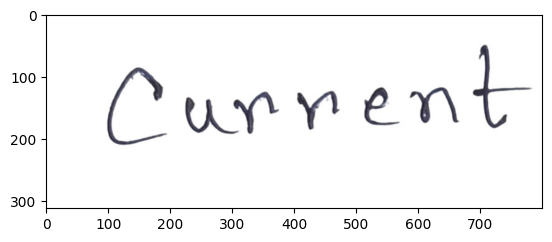

prediction value =  evfertlessly


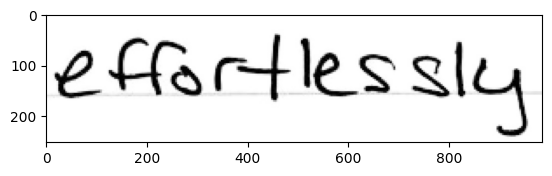

prediction value =  fovinly


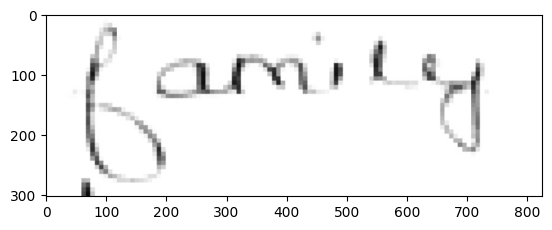

prediction value =  flow


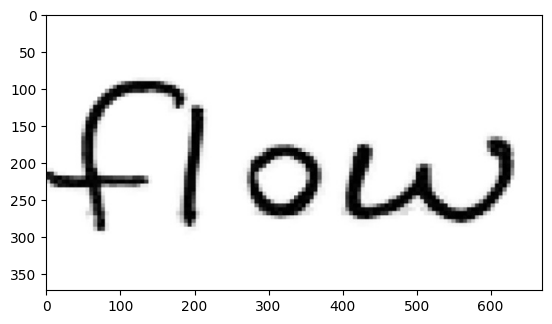

prediction value =  foevrer


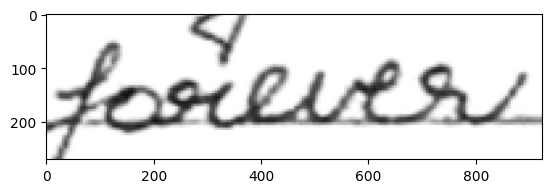

prediction value =  freehand


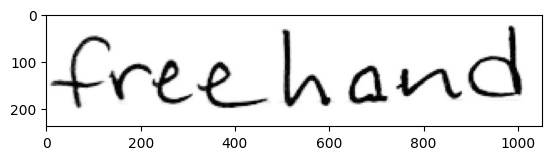

prediction value =  goals


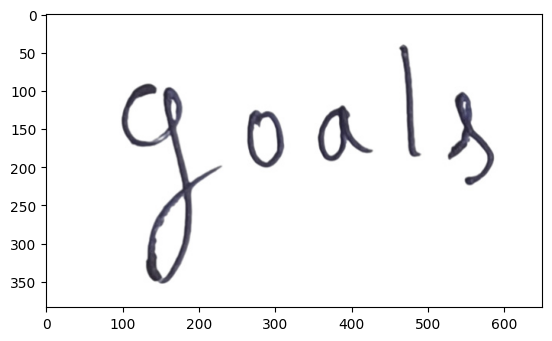

prediction value =  hordutitins


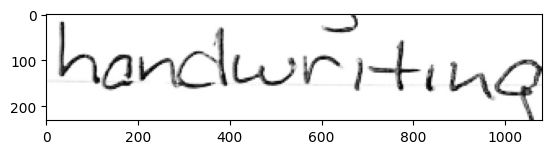

prediction value =  Important-


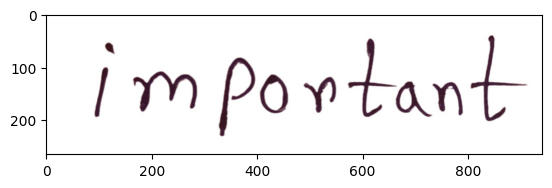

prediction value =  improve


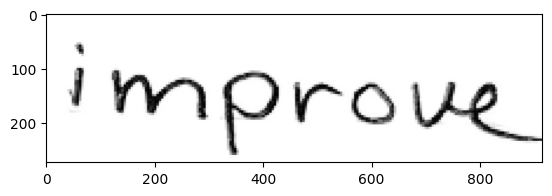

prediction value =  individual


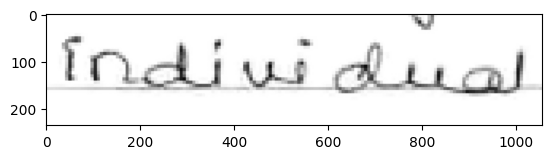

prediction value =  intervie


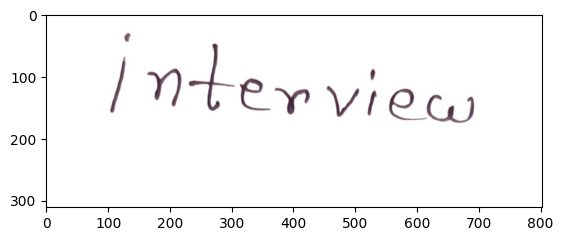

prediction value =  Tast


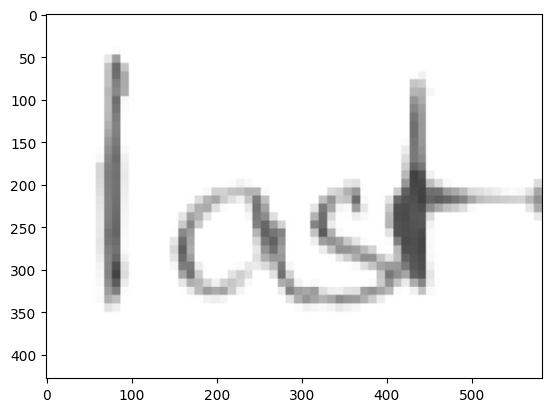

prediction value =  retershs


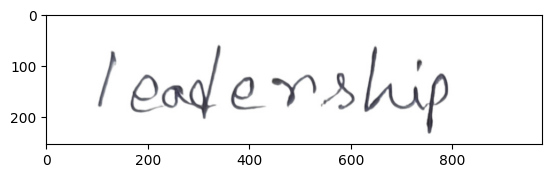

prediction value =  fines


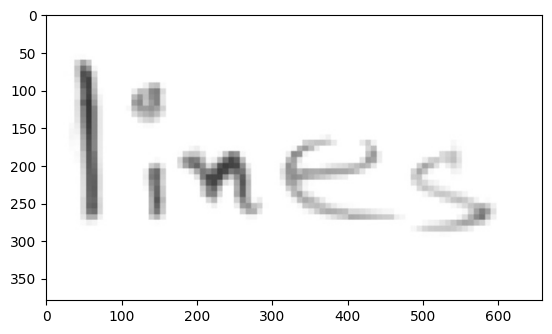

prediction value =  anre


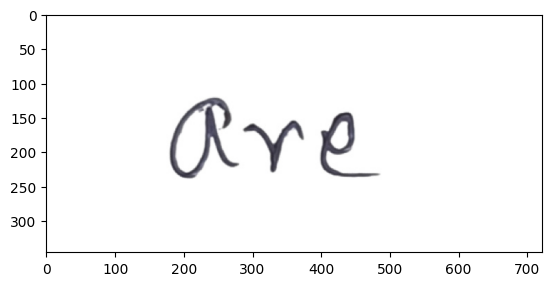

prediction value =  Doverst


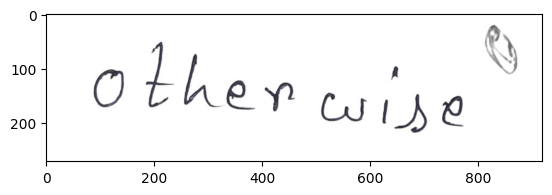

prediction value =  possibie


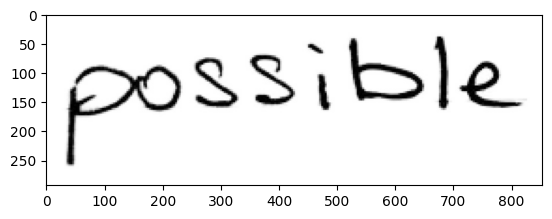

prediction value =  OR


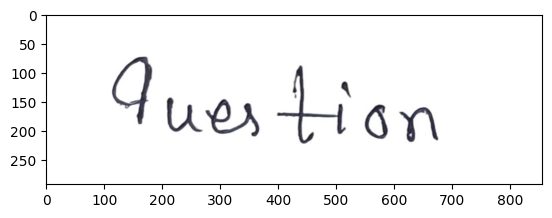

prediction value =  pmrte


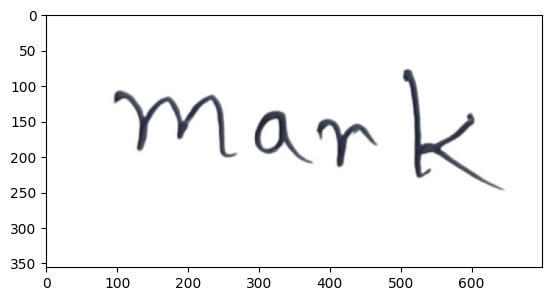

prediction value =  TIABIE


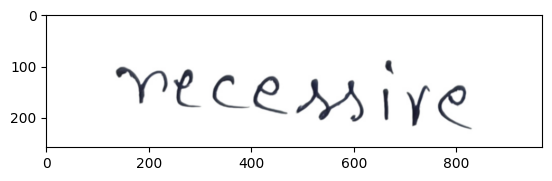

prediction value =  pesise


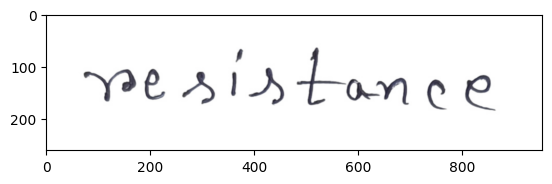

prediction value =  Rook


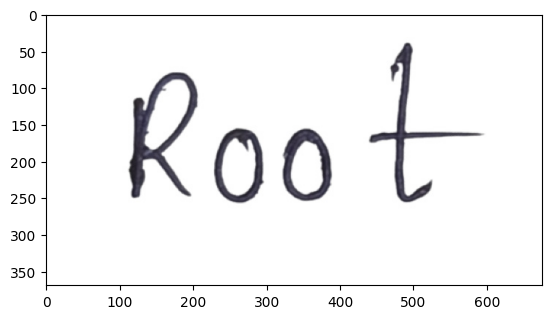

prediction value =  sosg


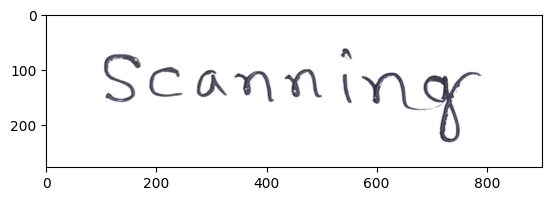

prediction value =  thay


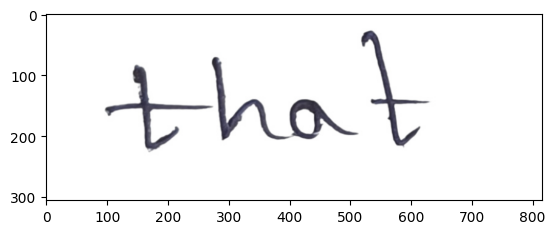

prediction value =  The


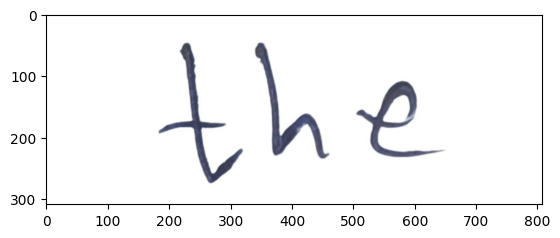

prediction value =  drais


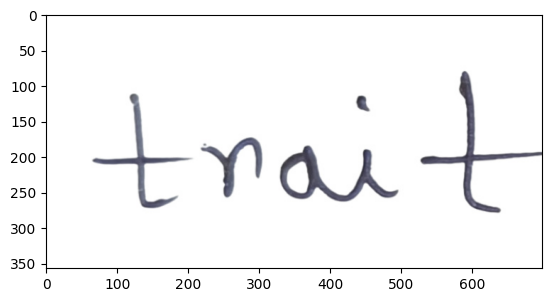

prediction value =  Wht


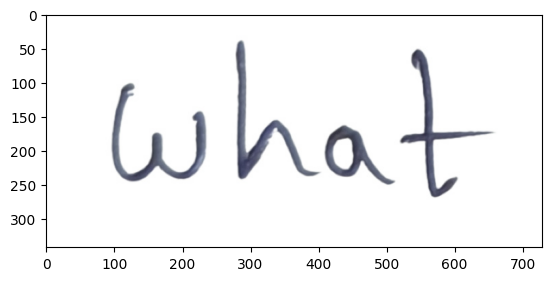

prediction value =  snteetnnes


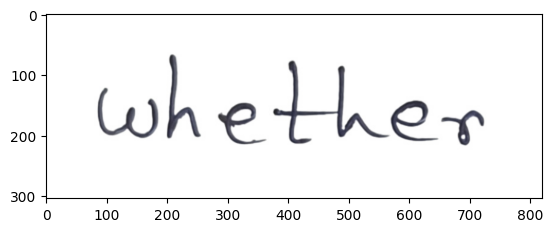

prediction value =  wheen


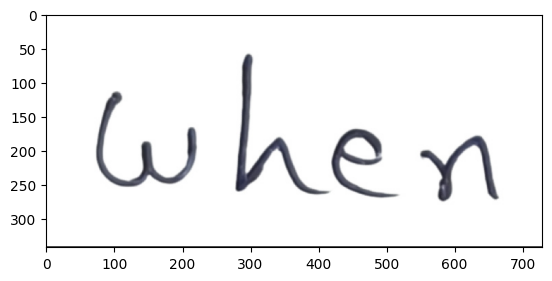

prediction value =  writth


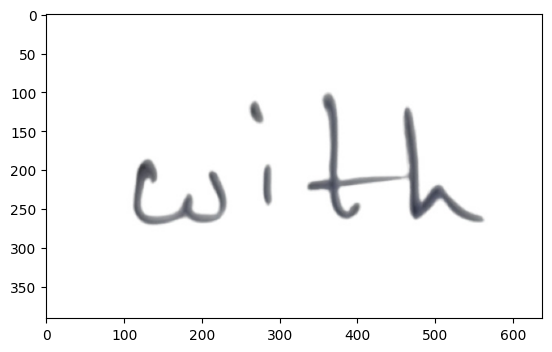

prediction value =  sero


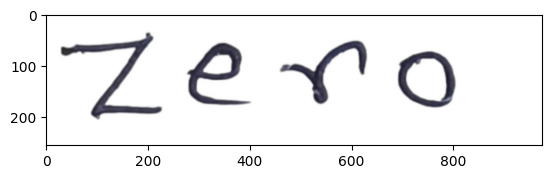

prediction value =  seros


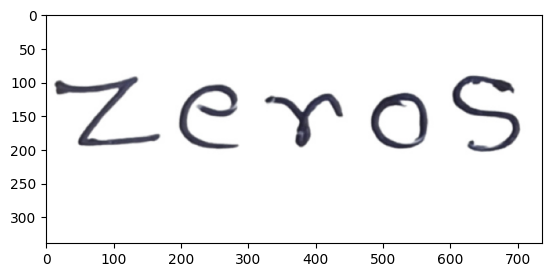

prediction value =  O


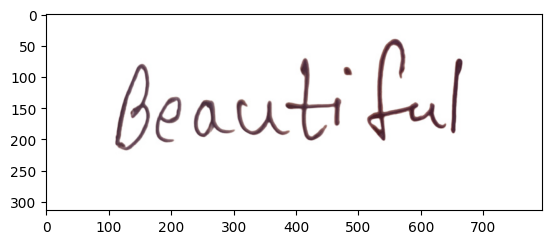

prediction value =  Aotnon


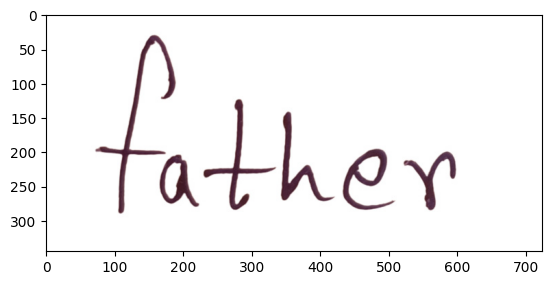

prediction value =  Biing


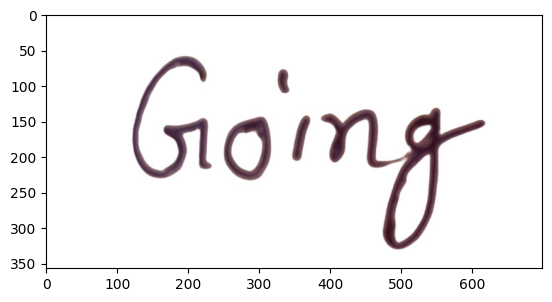

prediction value =  Brile


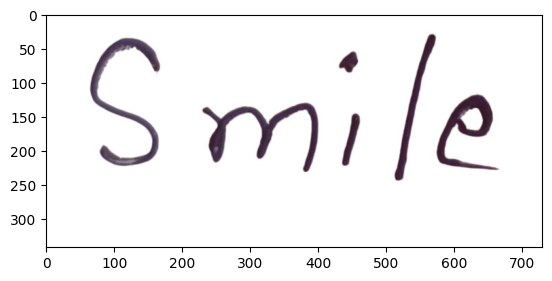

prediction value =  ugiy


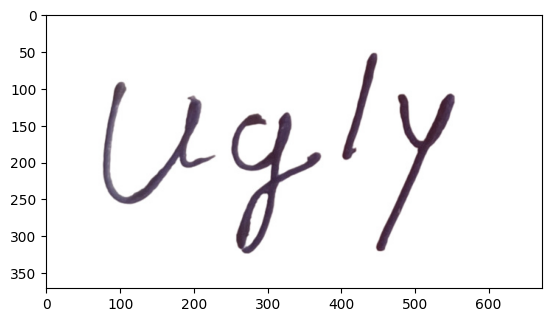

prediction value =  sefemte


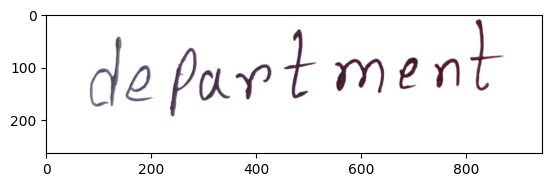

prediction value =  wheet


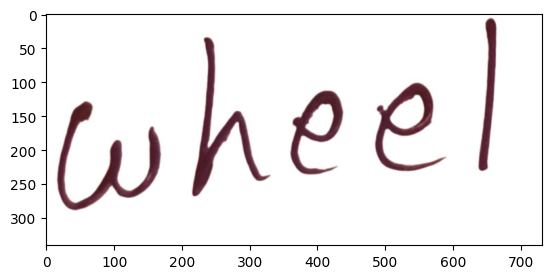

prediction value =  wheets


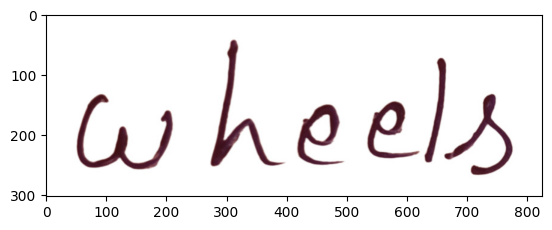

prediction value =  wori


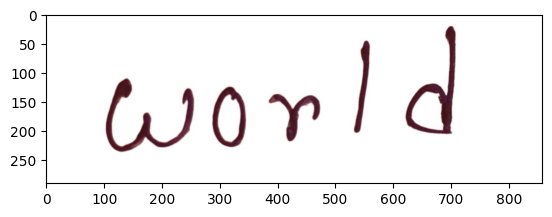

prediction value =  Kins


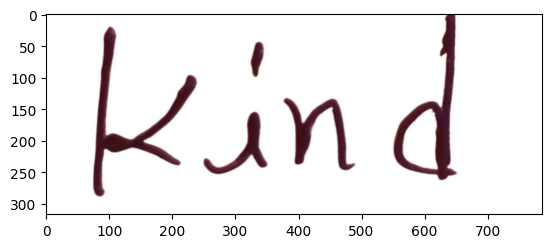

prediction value =  is


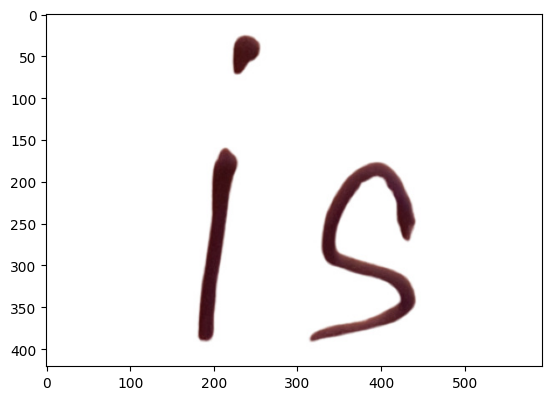

prediction value =  LAISTTSSCS


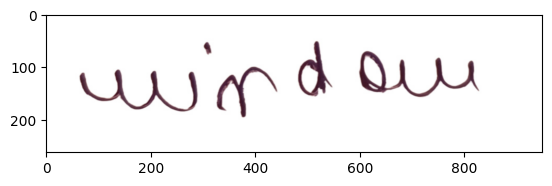

In [16]:
import matplotlib.pyplot as plt
import cv2

# Assuming test_x is a list of image file paths
for i in range(len(test_x)):
    image = cv2.imread(test_x[i])
    print("prediction value = ",prediction[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [15]:
model.load_weights('/Users/rishavghosh/Downloads/new_my_model.h5')

prediction = []
for batch in test_dataset.as_numpy_iterator():
    preds = model.predict(batch)
    prediction.extend(ctc_decoder(preds))

y_true = test_data.loc[0:len(test_data), 'Identify']
correct_char = 0
total_char = 0
correct = 0
for i in range(len(test_data)):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr:
        correct += 1

print('Correct characters predicted : %.2f%%' % (correct_char * 100 / total_char))
print('Correct words predicted      : %.2f%%' % (correct * 100 / len(test_data)))

/Users/rishavghosh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step
Correct characters predicted : 69.35%
Correct words predicted      : 60.00%


prediction value =  paeiis


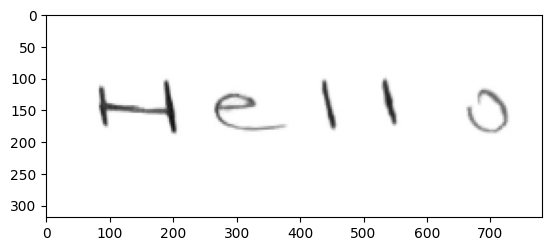

prediction value =  ERCZTTR


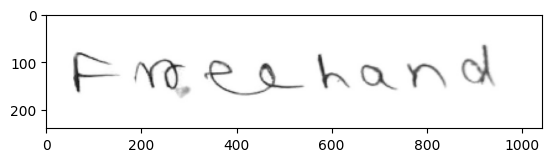

prediction value =  Imagine


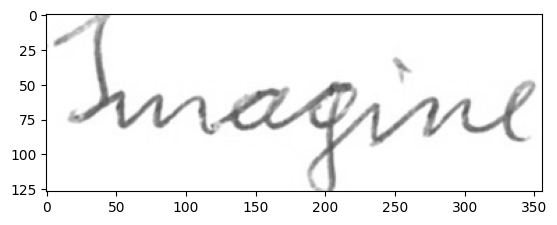

prediction value =  paper


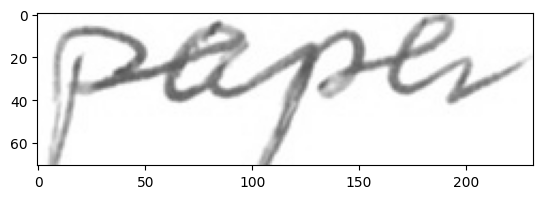

prediction value =  wast


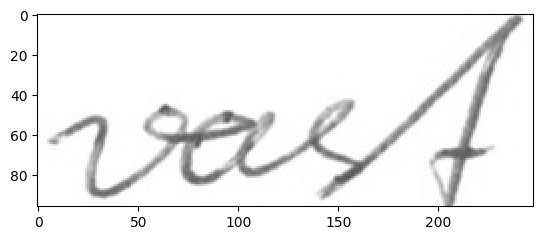

prediction value =  sheet


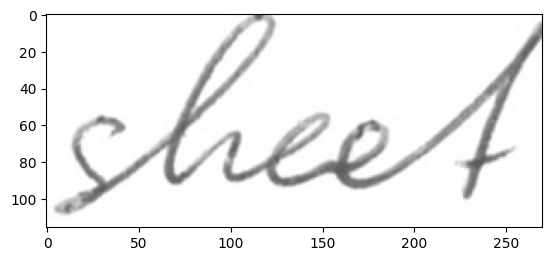

prediction value =  of


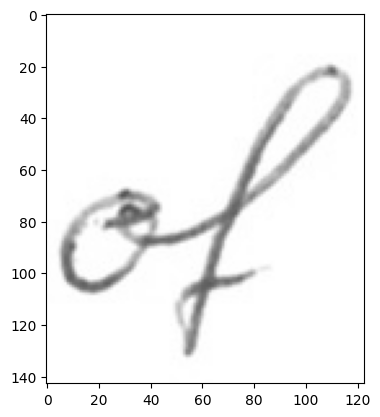

prediction value =  of


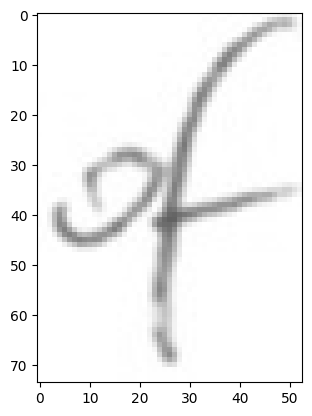

prediction value =  may


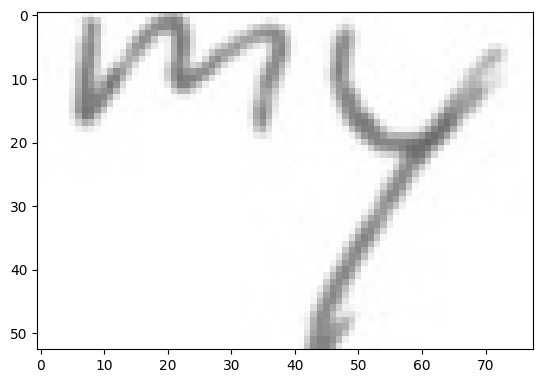

prediction value =  country


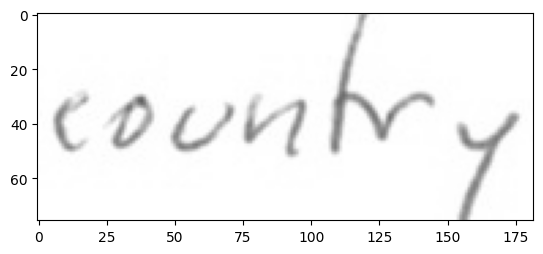

prediction value =  and


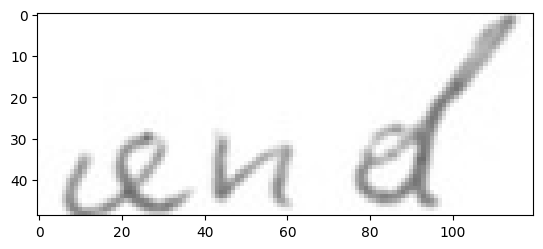

prediction value =  &quo;


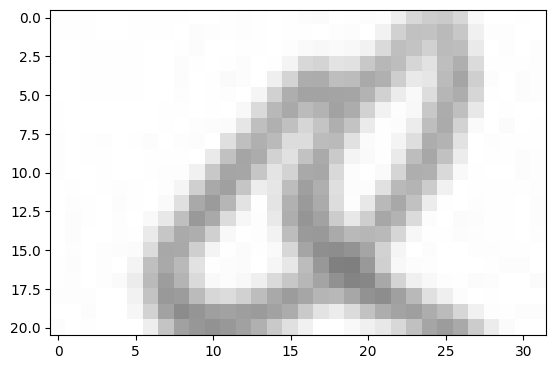

prediction value =  few


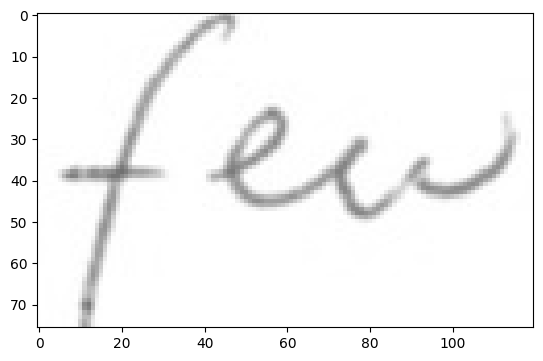

prediction value =  years


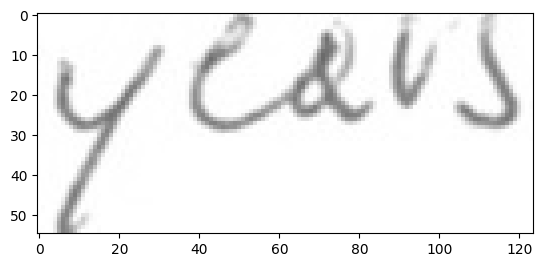

prediction value =  eapy


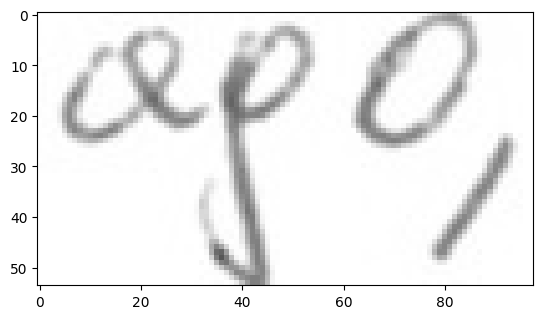

In [16]:
import matplotlib.pyplot as plt
import cv2

# Assuming test_x is a list of image file paths
for i in range(len(test_x)):
    image = cv2.imread(test_x[i])
    print("prediction value = ",prediction[i])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

In [13]:
import cv2

def is_grayscale(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Check if the image is read successfully
    if img is None:
        print(f"Unable to read the image at path: {image_path}")
        return False

    # Check the number of channels
    return len(img.shape) < 3 or img.shape[2] == 1

# Example usage
image_path = '/Users/rishavghosh/Downloads/output images/img001-003.png'
if is_grayscale(image_path):
    print("The image is grayscale.")
else:
    print("The image is not grayscale.")


The image is grayscale.


In [14]:
import os
import cv2

def convert_images_to_grayscale(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all files in the input folder
    image_files = os.listdir(input_folder)

    for image_file in image_files:
        # Construct full paths for input and output images
        input_image_path = os.path.join(input_folder, image_file)
        output_image_path = os.path.join(output_folder, image_file)

        try:
            # Read the image
            img = cv2.imread(input_image_path)

            # Check if the image is loaded successfully
            if img is None:
                raise Exception(f"Error: Unable to read image '{input_image_path}'")

            # Convert the image to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image
            cv2.imwrite(output_image_path, gray_img)

        except Exception as e:
            print(f"Error processing '{input_image_path}': {e}")

# Example usage
input_folder_path = '/Users/rishavghosh/Downloads/clg handwritten/iam_words/words/s02'
output_folder_path = '/Users/rishavghosh/Downloads/output images'

convert_images_to_grayscale(input_folder_path, output_folder_path)
